<a href="https://colab.research.google.com/github/qmeng222/CNN/blob/main/CNN/CNN4MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layers in this CNN:

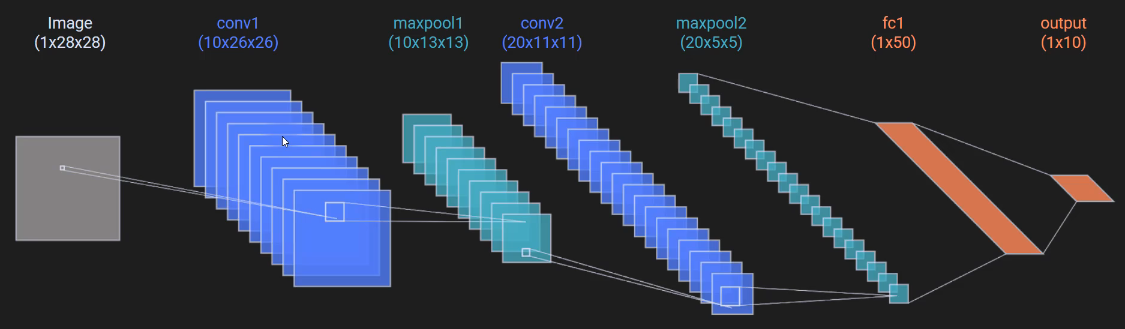

In [52]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary # provide summary info about the total count of parameters in the model

import matplotlib.pyplot as plt
import matplotlib_inline as inl
inl.backend_inline.set_matplotlib_formats("svg")

In [53]:
# import dataset (comes with colab)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels & remove labels from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to [0 1]
dataNorm = data / np.max(data)
print(dataNorm.shape) # (20000, 784)

# reshape:
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28) # 20000 imgs, 1 channel (grayscale), 28x28 pixels
print(dataNorm.shape) # (20000, 1, 28, 28)

(20000, 784)
(20000, 1, 28, 28)


In [54]:
# Step 1: np array -> torch tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.1)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

# Step 3: torch tensor -> torch Dataset obj
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: torch Dataset obj -> torch DataLoader obj
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([18000, 1, 28, 28]) torch.Size([2000, 1, 28, 28]) torch.Size([18000]) torch.Size([2000])


In [55]:
# check size (images x channels x W x H):
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

In [56]:
def createTheMNISTNet(printtoggle=False): # introduce new variable

  # create a class for the model
  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # convolution layers:
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1) # (inChans, outChans, k, s, p)
      # size: np.floor( (28+2*1-5)/1 )+1 -> 26/2=13 as max pooling using a spatial extent of 2
      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 -> 11/2=5 as max pooling using a spatial extent of 2

      # compute the number of units into fc1 layer:
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # maxpool2 -> fc1, fc1 layer has no padding or kernel (set to 0, 1)
      expectSize = 20*int(expectSize**2) # 20 feature maps, squared for 2D feature maps

      # fc1 layer
      self.fc1 = nn.Linear(expectSize,50)

      # output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2)) # 2 is the spatial extent for max pooling
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2)) # 2 is the spatial extent for max pooling
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape: [32, 20, 5, 5] -> [32, 500]
      # print("👀1", x.shape.numel()) # 16000=32x20x5x5
      # print("👀2", x.shape) # [32, 20, 5, 5]
      nUnits = x.shape.numel()/x.shape[0] # 16000/32=500
      # x.shape.numel(): return the total number of elements in the array `x`
      # x.shape[0]: total number of data samples
      x = x.view(-1,int(nUnits)) # [32, 500]
      # -1 means this dimension will be automatically calculated based on the total number of elements in `x`
      # reshap into a 2D array with a fixed number of columns (units) and a varying number of rows (images)
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}\n')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() already incorporates log softmax

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net, lossfun, optimizer

In [57]:
# test the model with one batch:

net,lossfun,optimizer = createTheMNISTNet(True) # printtoggle=False=True

X,y = next(iter(train_loader)) # extract one batch
yHat = net(X)
print("y shape:", y.shape) # labels shape
print("yHat shape:", yHat.shape, "\n") # output shape

# compute the loss
loss = lossfun(yHat,y)
print('loss:', loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])

y shape: torch.Size([32])
yHat shape: torch.Size([32, 10]) 

loss: tensor(2.3240, grad_fn=<NllLossBackward0>)


In [58]:
# count the total number of parameters in the model:
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


👆 Interpretations:

---

- Layer conv2/pool2: torch.Size([2, 20, 5, 5])
- Vectorize: torch.Size([2, 500])
- Layer fc1: torch.Size([2, 50])

20x5x5 = 500 units -> 500 units x 50 units = 25000

- Linear-3         [-1, 50]        25,050

25000+50(bias)=25050

In [60]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # loop over epochs
  for epochi in range(numepochs):
    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []

    for X,y in train_loader:
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [61]:
# run the model:
trainAcc,testAcc,losses,net = function2trainTheModel()

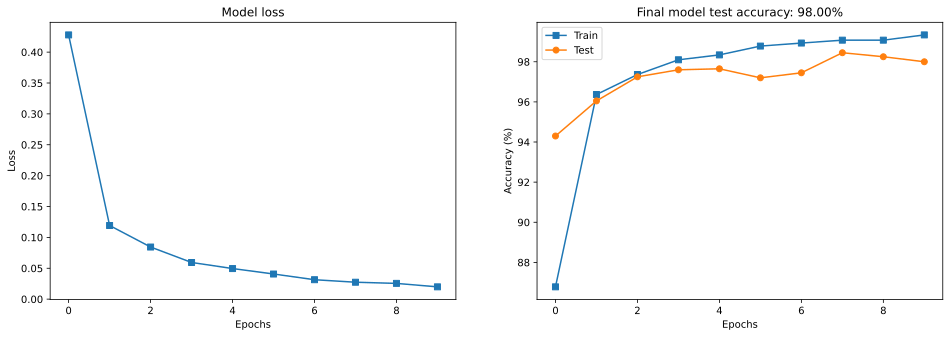

In [62]:
# show the results:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()